In [3]:
import pandas as pd

In [1]:
from google.colab import files
uploaded=files.upload()

Saving exchange_rate.csv to exchange_rate.csv


In [5]:
data=pd.read_csv('exchange_rate.csv')
data

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [7]:
data.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


initial exploration

In [9]:
import matplotlib.pyplot as plt

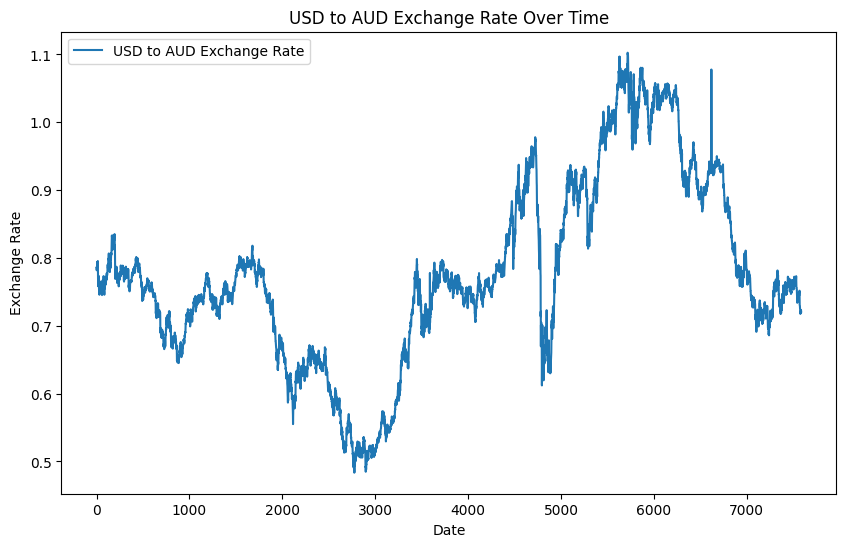

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(data['Ex_rate'], label='USD to AUD Exchange Rate')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

DATA PREPROCESSING

In [17]:
missing_data = data.isnull().sum()
missing_data

,0
date,0
Ex_rate,0


In [18]:
data.fillna(method= 'ffill',inplace=True)

<ipython-input-18-706471381649>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method= 'ffill',inplace=True)


MODEL BUILDING - ARIMA

In [19]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

Index(['date', 'Ex_rate'], dtype='object')


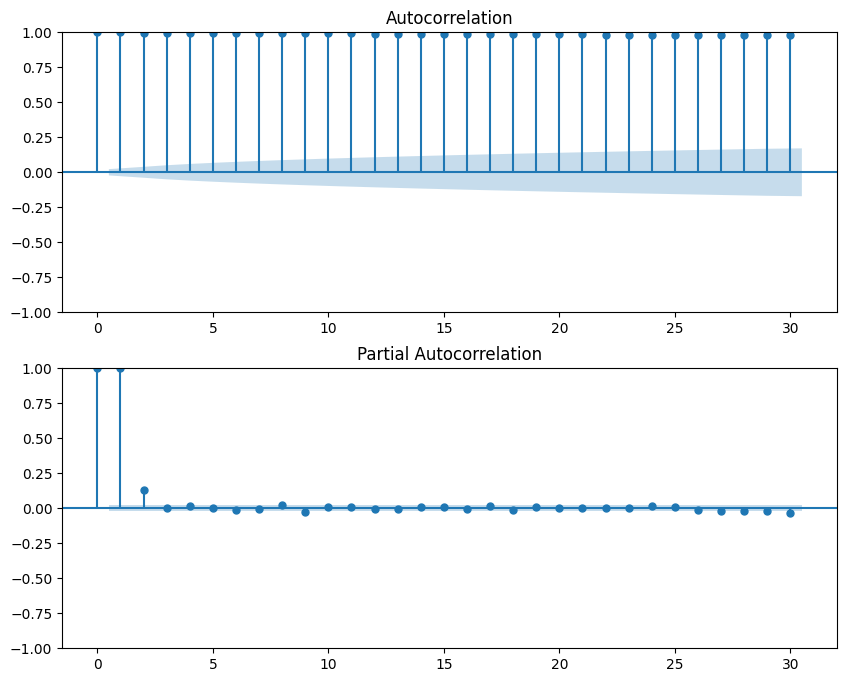

In [21]:
fig, ax = plt.subplots(2, figsize=(10, 8))
print(data.columns)
plot_acf(data['Ex_rate'], lags=30, ax=ax[0])
plot_pacf(data['Ex_rate'], lags=30, ax=ax[1])
plt.show()

model fitting

In [24]:
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(data['Ex_rate'], order=(1, 1, 1))
model_arima_fit = model_arima.fit()


In [26]:
print( model_arima.fit().summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Thu, 12 Sep 2024   AIC                         -56102.322
Time:                        06:27:28   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

Diagnostics

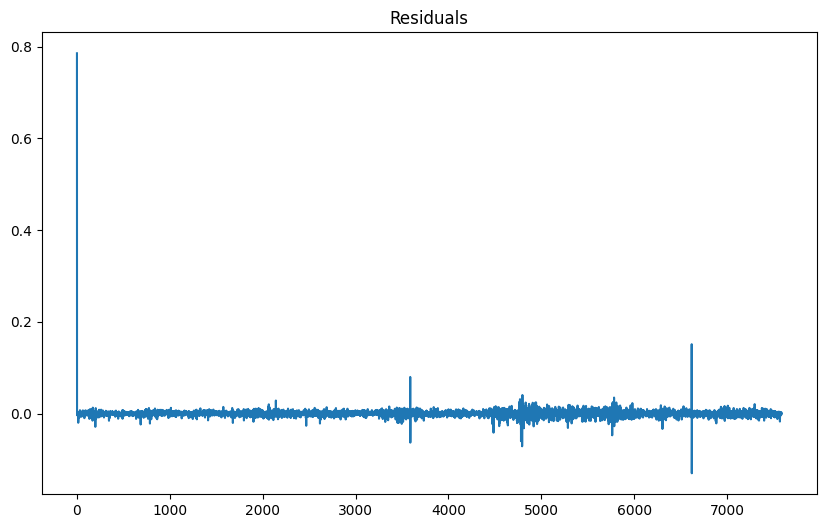

<Figure size 1000x600 with 0 Axes>

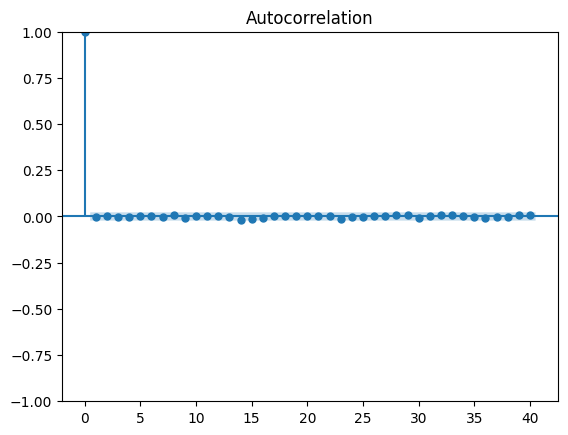

In [28]:

residuals = model_arima_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=40)
plt.show()


Forecasting

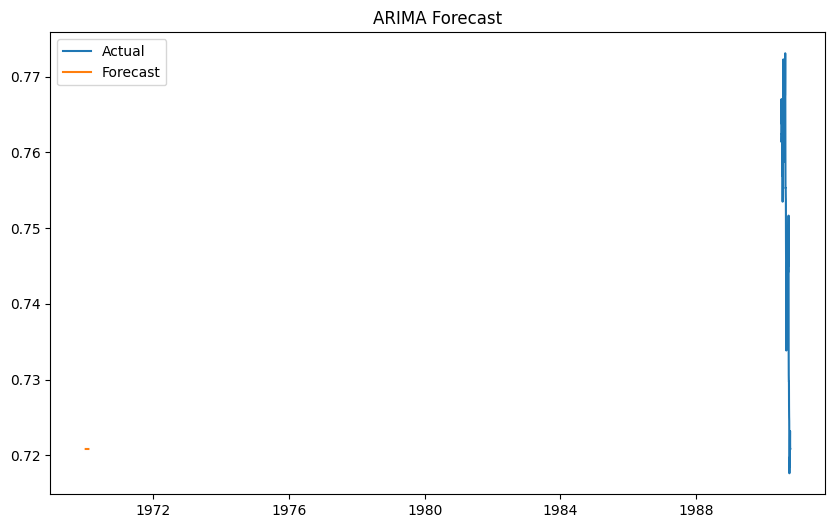

In [31]:

forecast = model_arima_fit.forecast(steps=30)
plt.figure(figsize=(10, 6))
plt.plot(data.index[-100:], data['Ex_rate'].iloc[-100:], label='Actual')
plt.plot(pd.date_range(start=data.index[-1], periods=31, freq='D')[1:], forecast, label='Forecast')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()


MODEL BUILDING - EXPONENTIAL SMOOTHING

1. Model Selection:

In [32]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model_exp = ExponentialSmoothing(data['Ex_rate'], trend='add', seasonal=None, seasonal_periods=12)
model_exp_fit = model_exp.fit()
print(model_exp_fit.summary())


                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77641.009
Trend:                         Additive   BIC                         -77613.272
Seasonal:                          None   AICC                        -77640.998
Seasonal Periods:                  None   Date:                 Thu, 12 Sep 2024
Box-Cox:                          False   Time:                         06:35:53
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8700406                alpha                 True
smoothing_trend             0.0000

Model Fitting and Forecasting:

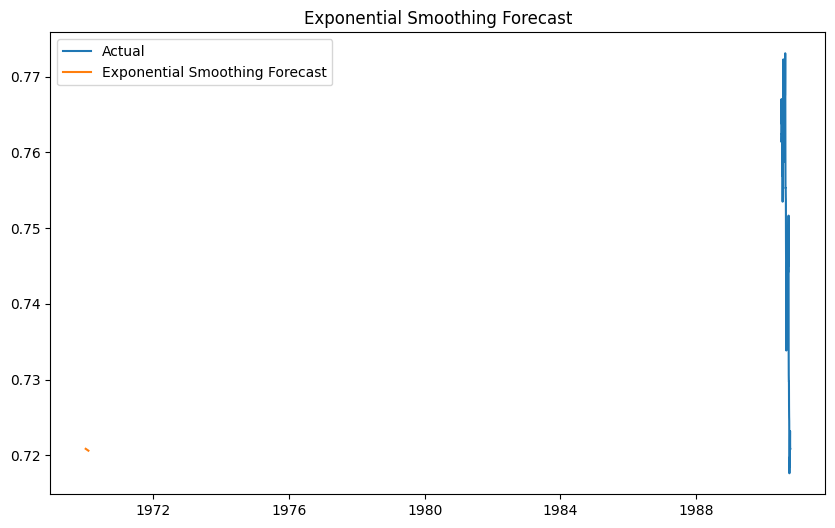

In [33]:
exp_forecast = model_exp_fit.forecast(steps=30)

plt.figure(figsize=(10, 6))
plt.plot(data.index[-100:], data['Ex_rate'].iloc[-100:], label='Actual')
plt.plot(pd.date_range(start=data.index[-1], periods=31, freq='D')[1:], exp_forecast, label='Exponential Smoothing Forecast')
plt.title('Exponential Smoothing Forecast')
plt.legend()
plt.show()


Evaluation and Comparison

Compute Error Metrics:


In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

actual = data['Ex_rate'][-30:]
arima_forecast = model_arima_fit.forecast(steps=30)
exp_forecast = model_exp_fit.forecast(steps=30)

mae_arima = mean_absolute_error(actual, arima_forecast)
rmse_arima = np.sqrt(mean_squared_error(actual, arima_forecast))
mape_arima = np.mean(np.abs((actual - arima_forecast) / actual)) * 100

mae_exp = mean_absolute_error(actual, exp_forecast)
rmse_exp = np.sqrt(mean_squared_error(actual, exp_forecast))
mape_exp = np.mean(np.abs((actual - exp_forecast) / actual)) * 100

print(f'ARIMA - MAE: {mae_arima}, RMSE: {rmse_arima}, MAPE: {mape_arima}%')
print(f'Exponential Smoothing - MAE: {mae_exp}, RMSE: {rmse_exp}, MAPE: {mape_exp}%')


ARIMA - MAE: 0.012724006489305202, RMSE: 0.016982710912755217, MAPE: nan%
Exponential Smoothing - MAE: 0.012755756156713368, RMSE: 0.017005229952751045, MAPE: nan%
